# Checking GPU available for trining

In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Importing libraries

In [2]:
#importing the libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import json
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, GlobalMaxPooling1D, Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import joblib

# Data importing

In [3]:
res = json.load(open('covid_responses.json'))
res

{'greeting': ['Hi. How can I assist you today with your COVID-19 concerns?',
  'Hi! I am here to help you navigate COVID-19. What can I do for you?',
  'Greetings! As a COVID-19 checker, I am here to provide you with the information and resources you need to stay safe and healthy.',
  'Good to see you! Let me know how I can help you with the COVID-19.',
  'Hi, how can I help you today? I am here to support you with all of your COVID-19 related needs.',
  'Hello! Are you tested positive or shown any symptoms of COVID?',
  'Hello! Are you currently having COVID or did you recover from COVID?',
  'Hello! Could you specify the condition you are facing?'],
 'goodbye': ['Okay, Bye',
  'Have a nice day',
  'Goodbye',
  'see you later',
  'nice conversation. bye',
  'okay. Have a nice day',
  'Take care',
  'Yeah Sure, Will talk to you later',
  'Okay , Take care'],
 'covid_intro': ['Coronaviruses are a large family of viruses which may cause illness in animals or humans. COVID-19 is the infec

In [4]:
file = pd.read_csv('data.csv')
data = file[['inputs', 'tags']]
data = data.sample(frac=1)
data.head()

,inputs,tags
316,do coronavirus symptoms come on quickly,symptoms
933,What can I do to avoid catching the virus?,prevention
980,Can you give me the phone number?,emergency
700,What drug is most effective in treating covid-19?,treatments
338,Do you know if the symptoms of COVID-19 consis...,symptoms


# cleaning data

In [5]:
import string
data['inputs'] = data['inputs'].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
data['inputs'] = data['inputs'].apply(lambda wrd: ''.join(wrd))
data

,inputs,tags
316,do coronavirus symptoms come on quickly,symptoms
933,what can i do to avoid catching the virus,prevention
980,can you give me the phone number,emergency
700,what drug is most effective in treating covid19,treatments
338,do you know if the symptoms of covid19 consistent,symptoms
...,...,...
570,can someone take ibuprofen for the virus,treatments
419,how to known if you have the corona virus,symptoms
1048,my child tested positive for covid19,children
76,i want to know about coronavirus,covid_intro


In [6]:
#tokenize the data
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(data['inputs'])
train = tokenizer.texts_to_sequences(data['inputs'])
#apply padding
from tensorflow.keras.preprocessing.sequence import pad_sequences
x_train = pad_sequences(train)

#encoding the outputs
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(data['tags'])
input_shape = x_train.shape[1]
print(input_shape)

18


# define vocabulary

In [7]:
vocabulary = len(tokenizer.word_index)
print("number of unique words : ",vocabulary)
output_length = le.classes_.shape[0]
print("output length: ",output_length)

number of unique words :  788
output length:  10


# creating the LSTM model

In [8]:
i = Input(shape=(input_shape,))
x = Embedding(vocabulary+1,10)(i)
x = LSTM(10,return_sequences=True)(x)
x = Flatten()(x)
x = Dense(output_length,activation="softmax")(x)
model  = Model(i,x)

# compiling the model

In [9]:
model.compile(loss="sparse_categorical_crossentropy",optimizer='adam',metrics=['accuracy'])

# training the model

In [10]:
train = model.fit(x_train,y_train,epochs=200)

Epoch 1/200
33/33 [==============================] - 4s 7ms/step - loss: 2.1736 - accuracy: 0.2131
Epoch 2/200
33/33 [==============================] - 0s 6ms/step - loss: 1.7941 - accuracy: 0.2898
Epoch 3/200
33/33 [==============================] - 0s 6ms/step - loss: 1.7615 - accuracy: 0.2888
Epoch 4/200
33/33 [==============================] - 0s 6ms/step - loss: 1.7487 - accuracy: 0.2888
Epoch 5/200
33/33 [==============================] - 0s 6ms/step - loss: 1.7284 - accuracy: 0.2888
Epoch 6/200
33/33 [==============================] - 0s 6ms/step - loss: 1.6921 - accuracy: 0.2907
Epoch 7/200
33/33 [==============================] - 0s 6ms/step - loss: 1.6180 - accuracy: 0.3873
Epoch 8/200
33/33 [==============================] - 0s 5ms/step - loss: 1.4988 - accuracy: 0.5559
Epoch 9/200
33/33 [==============================] - 0s 5ms/step - loss: 1.3544 - accuracy: 0.6184
Epoch 10/200
33/33 [==============================] - 0s 5ms/step - loss: 1.1787 - accuracy: 0.7102
Epoch 11/

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 18)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 18, 10)            7890      
_________________________________________________________________
lstm (LSTM)                  (None, 18, 10)            840       
_________________________________________________________________
flatten (Flatten)            (None, 180)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                1810      
Total params: 10,540
Trainable params: 10,540
Non-trainable params: 0
_________________________________________________________________


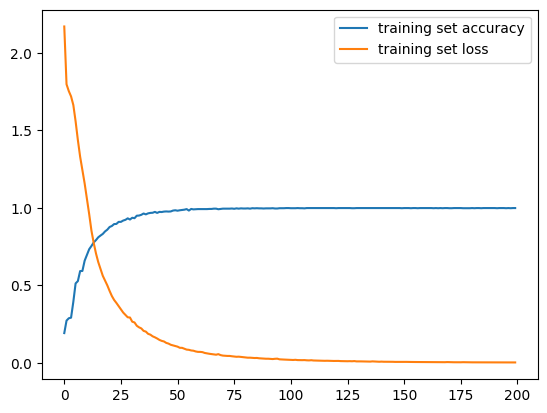

In [13]:
#plotting model accuracy
plt.plot(train.history['accuracy'],label='training set accuracy')
plt.plot(train.history['loss'],label='training set loss')
plt.legend()
plt.savefig('model_accuracy.png', dpi=300, bbox_inches='tight')

# saving model as h5

In [14]:
model.save('mychatbot.h5')

# loading saved model

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('mychatbot.h5')

# checking responses of COVID chatbot

In [17]:
#chatting
import random


while True:
  texts_p = []
  prediction_input = input('You : ')

  #removing punctuation and converting to lowercase
  prediction_input = [letters.lower() for letters in prediction_input if letters not in string.punctuation]
  prediction_input = ''.join(prediction_input)
  texts_p.append(prediction_input)

  #tokenizing and padding
  prediction_input = tokenizer.texts_to_sequences(texts_p)
  prediction_input = np.array(prediction_input).reshape(-1)
  prediction_input = pad_sequences([prediction_input],input_shape)

  #getting output from model
  output = model1.predict(prediction_input)
  output = output.argmax()

  #finding the right tag and predicting
  response_tag = le.inverse_transform([output])[0]
  print("Chatbot : ",random.choice(res[response_tag]))
  if response_tag == "goodbye":
    break

Chatbot :  Mode of transmission includes through respiratory droplets, contact of contaminated surfaces or objects, short-range aerosol or short-range airborne transmission. The virus can also spread in poorly ventilated and/or crowded indoor settings. Most estimates of the incubation period range from 1 to 14 days, and some variants, such as the Omicron variant, may have even shorter incubation period of around 3 days.
Chatbot :  Around 1 out of every 6 people who gets COVID-19 becomes seriously ill and develops difficulty breathing. Older people, and those with underlying medical problems like high blood pressure, heart problems or diabetes, are more likely to develop serious illness. People with fever, cough and difficulty breathing should seek medical attention. In some cases, you might continue to have a cough or feel tired after your other symptoms have improved, but this does not mean that you are still infectious.
Chatbot :  Can you please share details why you think that
Chatb